In [1]:
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension 
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :]
    
    return img

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

Image shape: (1, 341, 512, 3)


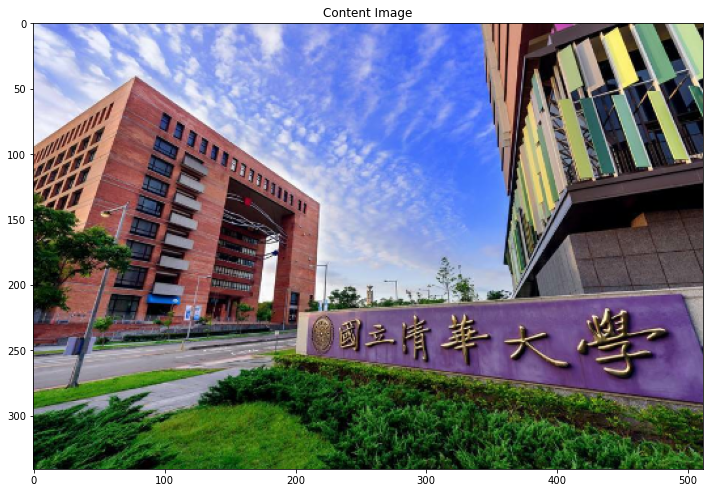

In [5]:
content_path = './dataset/content_nthu.jpg'
content_image = load_img(content_path)
print('Image shape:', content_image.shape)
imshow(content_image, 'Content Image')

Image shape: (1, 405, 511, 3)


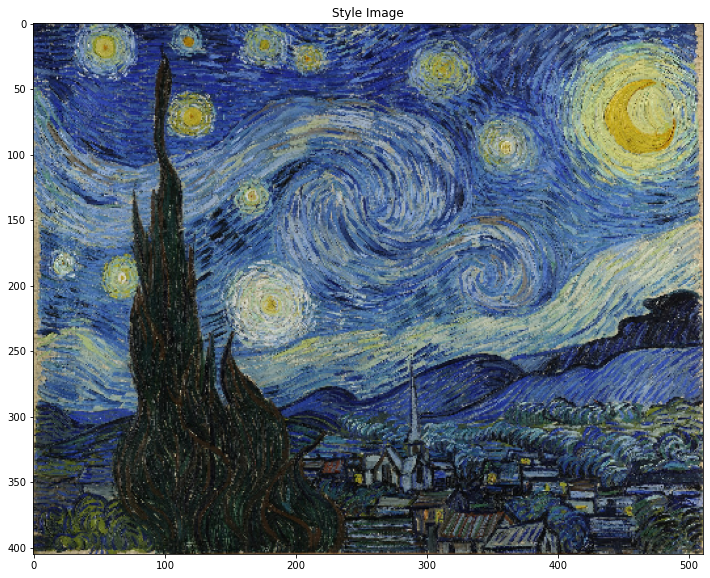

In [6]:
style_path = './dataset/style_starry_night.jpg'
style_image = load_img(style_path)
print('Image shape:', style_image.shape)
imshow(style_image, 'Style Image')

In [7]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [8]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [10]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 405, 511, 64)
  min:  0.0
  max:  652.5946
  mean:  24.880405

block2_conv1
  shape:  (1, 202, 255, 128)
  min:  0.0
  max:  2693.6472
  mean:  154.37915

block3_conv1
  shape:  (1, 101, 127, 256)
  min:  0.0
  max:  6222.724
  mean:  143.93526

block4_conv1
  shape:  (1, 50, 63, 512)
  min:  0.0
  max:  17157.703
  mean:  566.56866

block5_conv1
  shape:  (1, 25, 31, 512)
  min:  0.0
  max:  3866.7495
  mean:  47.18097



In [11]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [12]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [13]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.105069004
    max:  19345.35
    mean:  937.96106

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  178938.14
    mean:  28008.354

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.049529716
    max:  1207017.6
    mean:  32819.58

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  9239154.0
    mean:  420604.8

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  180992.8
    mean:  3430.2556

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  1434.7812
    mean:  21.457201


In [14]:
def style_content_loss(outputs, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [15]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [16]:
@tf.function()
def train_step(image, style_weight, content_weight, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_weight, content_weight)

    # tape.gradient: d_loss/d_image
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight = 0
content_weight = 0

train_step(image, style_weight, content_weight, opt)
# train_step(image)
# train_step(image)
plt.imshow(image.read_value()[0])

# Part I

## 1. Implement total variational loss.

In [19]:
def total_variation_loss(image):
    # TODO
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    
    return tf.reduce_sum(tf.math.abs(x_var)) + tf.reduce_sum(tf.math.abs(y_var))

In [20]:
# @tf.function()
def train_step(image, total_variation_weight, style_weight, content_weight, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_weight, content_weight)
#         loss = style_content_loss(outputs)
        loss += total_variation_weight*total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

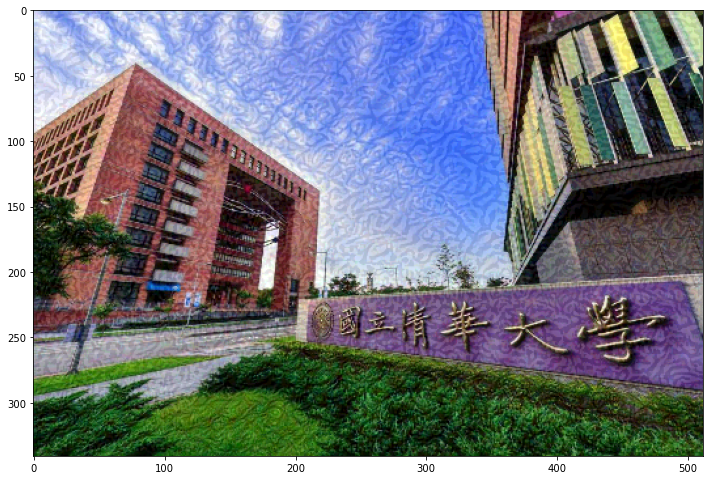

In [21]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

total_variation_weight = 10
style_weight = 1
content_weight = 1

train_step(image, total_variation_weight, style_weight, content_weight, opt)
train_step(image, total_variation_weight, style_weight, content_weight, opt)
train_step(image, total_variation_weight, style_weight, content_weight, opt)
plt.imshow(image.read_value()[0])

## 2. Change the weights for the style, content, and total variational loss

(1) style weight and content weight

Style Weight: 10000, Content Weight: 0.0001


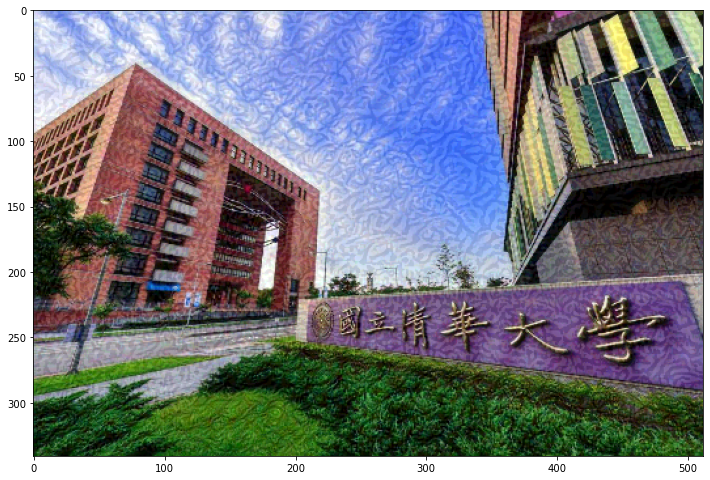

In [25]:
total_variation_weight = 10
style_weights = [1e-4, 1, 10000]
content_weights = [1e-4, 1, 10000]

for s in style_weights:
    for c in content_weights:
        print(f"Style Weight: {s}, Content Weight: {c}")
        
        style_targets = extractor(style_image)['style']
        content_targets = extractor(content_image)['content']

        image = tf.Variable(content_image)
        opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

        train_step(image, total_variation_weight, s, c, opt)
        train_step(image, total_variation_weight, s, c, opt)
        train_step(image, total_variation_weight, s, c, opt)
        plt.imshow(image.read_value()[0])

(2) total variation loss

Style Weight: 10000, Content Weight: 0.0001
Style Weight: 10000, Content Weight: 0.0001
Style Weight: 10000, Content Weight: 0.0001


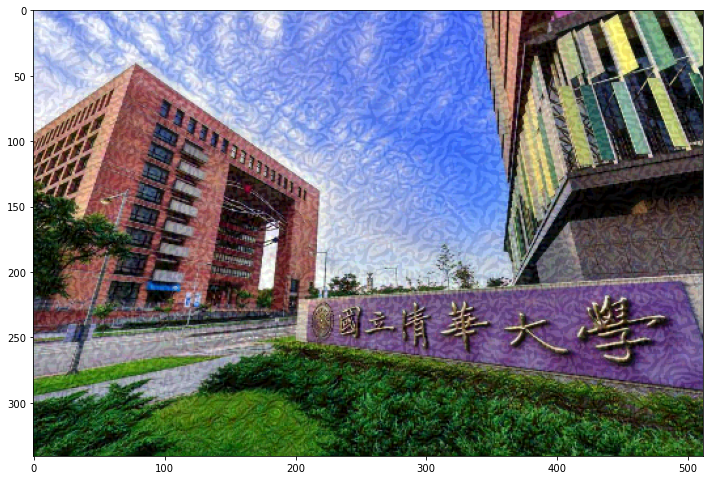

In [26]:
total_variation_weights = [1e-4, 1, 10000]
style_weight = 1
content_weight = 1

for v_w in total_variation_weights:
        print(f"Style Weight: {s}, Content Weight: {c}")
        
        style_targets = extractor(style_image)['style']
        content_targets = extractor(content_image)['content']

        image = tf.Variable(content_image)
        opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

        train_step(image, v_w, style_weight, content_weight, opt)
        train_step(image, v_w, style_weight, content_weight, opt)
        train_step(image, v_w, style_weight, content_weight, opt)
        plt.imshow(image.read_value()[0])

## 3. Use other layers in the model 

In [28]:
'''
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
'''

# Content layer where will pull our feature maps
content_layers = ['block1_conv2'] 

# Style layer of interest
style_layers = ['block1_conv2',
                'block2_conv2',
                'block3_conv2', 
                'block4_conv2', 
                'block5_conv2']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [30]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [29]:
results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv2
    shape:  (1, 64, 64)
    min:  249.97441
    max:  824086.5
    mean:  17016.014

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.92908216
    max:  337111.9
    mean:  25975.418

   block3_conv2
    shape:  (1, 256, 256)
    min:  161.28531
    max:  846496.9
    mean:  48849.742

   block4_conv2
    shape:  (1, 512, 512)
    min:  0.0
    max:  8591570.0
    mean:  184166.22

   block5_conv2
    shape:  (1, 512, 512)
    min:  0.0
    max:  53292.453
    mean:  543.6075

Contents:
   block1_conv2
    shape:  (1, 341, 512, 64)
    min:  0.0
    max:  2791.8972
    mean:  122.81752


In [31]:
def style_content_loss(outputs, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [32]:
total_variation_weights = [1e-4, 1, 10000]
style_weight = 1
content_weight = 1

for v_w in total_variation_weights:
        print(f"Style Weight: {s}, Content Weight: {c}")
        
        style_targets = extractor(style_image)['style']
        content_targets = extractor(content_image)['content']

        image = tf.Variable(content_image)
        opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

        train_step(image, v_w, style_weight, content_weight, opt)
        train_step(image, v_w, style_weight, content_weight, opt)
        train_step(image, v_w, style_weight, content_weight, opt)
        plt.imshow(image.read_value()[0])

Style Weight: 10000, Content Weight: 0.0001
Style Weight: 10000, Content Weight: 0.0001
Style Weight: 10000, Content Weight: 0.0001


## 4. A brief report

1. 提升content weight: 將使結果與原圖更相近
2. 提升style weight: 將使結果風格更加強烈
3. 提升total variation weight: 將使結果雜訊較少
4. 在這邊我使用較淺層當作content layer，可發現結果比原本清晰很多，其原因為用較淺層作為content layer會保留較多content image的細節。

# Part II

In [33]:
%matplotlib inline

CONTENT_DIRS = ['./dataset/mscoco/test2014']
STYLE_DIRS = ['./dataset/wikiart/test']

# VGG19 was trained by Caffe which converted images from RGB to BGR,
# then zero-centered each color channel with respect to the ImageNet 
# dataset, without scaling.  
IMG_MEANS = np.array([103.939, 116.779, 123.68]) # BGR

IMG_SHAPE = (224, 224, 3) # training image shape, (h, w, c)
SHUFFLE_BUFFER = 1000
BATCH_SIZE = 32
EPOCHS = 30
STEPS_PER_EPOCH = 12000 // BATCH_SIZE

Sampled content images:


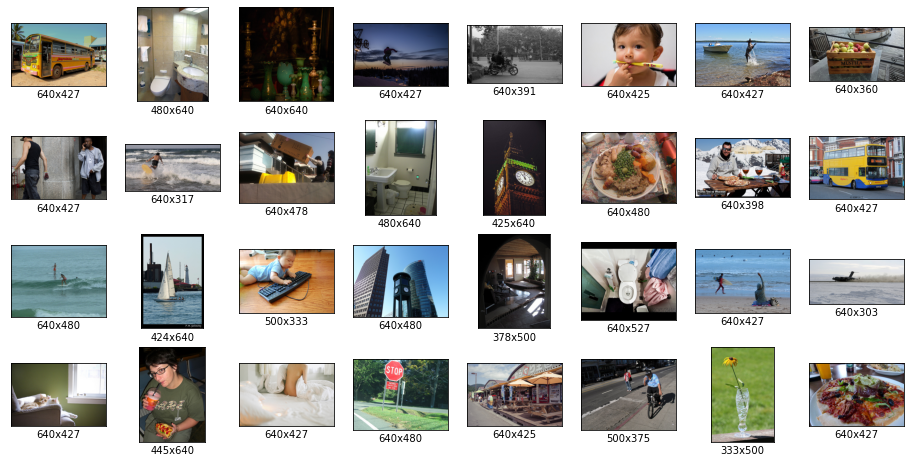

Sampled style images:


In [34]:
def sample_files(dir, num, pattern='**/*.jpg'):
    '''Samples files in a directory using the reservoir sampling.'''

    paths = Path(dir).glob(pattern) # list of Path objects
    sampled = []
    for i, path in enumerate(paths):
        if i < num:
            sampled.append(path) 
        else:
            s = random.randint(0, i)
            if s < num:
                sampled[s] = path
    return sampled

def plot_images(dir, row, col, pattern):
    paths = sample_files(dir, row*col, pattern)

    plt.figure(figsize=(2*col, 2*row))
    for i in range(row*col):
        im = Image.open(paths[i])
        w, h = im.size

        plt.subplot(row, col, i+1)
        plt.imshow(im)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'{w}x{h}')
    plt.show()

print('Sampled content images:')
plot_images(CONTENT_DIRS[0], 4, 8, pattern='*.jpg')

print('Sampled style images:')
plot_images(STYLE_DIRS[0], 4, 8, pattern='*.jpg')

In [35]:
def clean(dir_path, min_shape=None):
    paths = Path(dir_path).glob('**/*.jpg')
    deleted  = 0
    for path in paths:
        try:
            # Make sure we can decode the image
            im = tf.io.read_file(str(path.resolve()))
            im = tf.image.decode_jpeg(im)

            # Remove grayscale images 
            shape = im.shape
            if shape[2] < 3:
                path.unlink()
                deleted += 1

            # Remove small images
            if min_shape is not None:
                if shape[0] < min_shape[0] or shape[1] < min_shape[1]:
                    path.unlink()
                    deleted += 1
        except Exception as e:
            path.unlink()
            deleted += 1
    return deleted

for dir in CONTENT_DIRS:
    deleted = clean(dir)
print(f'#Deleted content images: {deleted}')

for dir in STYLE_DIRS:
    deleted = clean(dir)
print(f'#Deleted style images: {deleted}')

#Deleted content images: 39
#Deleted style images: 232


In [36]:
def preprocess_image(path, init_shape=(448, 448)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, init_shape)
    image = tf.image.random_crop(image, size=IMG_SHAPE)
    image = tf.cast(image, tf.float32)
    
    # Convert image from RGB to BGR, then zero-center each color channel with
    # respect to the ImageNet dataset, without scaling.
    image = image[..., ::-1] # RGB to BGR
    image -= (103.939, 116.779, 123.68) # BGR means
    return image

def np_image(image):
    image += (103.939, 116.779, 123.68) # BGR means
    image = image[..., ::-1] # BGR to RGB
    image = tf.clip_by_value(image, 0, 255)
    image = tf.cast(image, dtype='uint8')
    return image.numpy()

def build_dataset(num_gpus=1):
    c_paths = []
    for c_dir in CONTENT_DIRS:
        c_paths += Path(c_dir).glob('*.jpg')
    c_paths = [str(path.resolve()) for path in c_paths]
    s_paths = []
    for s_dir in STYLE_DIRS:
        s_paths += Path(s_dir).glob('*.jpg')
    s_paths = [str(path.resolve()) for path in s_paths]
    print(f'Building dataset from {len(c_paths):,} content images and {len(s_paths):,} style images... ', end='')

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    c_ds = tf.data.Dataset.from_tensor_slices(c_paths)
    c_ds = c_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    c_ds = c_ds.repeat()
    c_ds = c_ds.shuffle(buffer_size=SHUFFLE_BUFFER)

    s_ds = tf.data.Dataset.from_tensor_slices(s_paths)
    s_ds = s_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    s_ds = s_ds.repeat()
    s_ds = s_ds.shuffle(buffer_size=SHUFFLE_BUFFER)

    ds = tf.data.Dataset.zip((c_ds, s_ds))
    ds = ds.batch(BATCH_SIZE * num_gpus)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    print('done')
    return ds

In [37]:
ds = build_dataset()
c_batch, s_batch = next(iter(ds.take(1)))

print('Content batch shape:', c_batch.shape)
print('Style batch shape:', s_batch.shape)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(np_image(c_batch[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Content')

plt.subplot(1, 2, 2)
plt.imshow(np_image(s_batch[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Style')

plt.show()

Building dataset from 40,736 content images and 23,585 style images... done
Content batch shape: (32, 224, 224, 3)
Style batch shape: (32, 224, 224, 3)


In [38]:
class AdaIN(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super(AdaIN, self).__init__()
        self.epsilon = 1e-3
        
    def call(self, feats):
        content_feats, style_feats = feats
        
        content_mean, content_var = tf.nn.moments(content_feats, [1, 2], keepdims=True)
        style_mean, style_var = tf.nn.moments(style_feats, [1, 2], keepdims=True)
        
        return tf.nn.batch_normalization(content_feats, content_mean, content_var, style_mean, tf.sqrt(style_var), 1e-9)

In [39]:
class ArbitraryStyleTransferNet(tf.keras.Model):
    CONTENT_LAYER = 'block4_conv1'
    STYLE_LAYERS = ('block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1')

    @staticmethod
    def declare_decoder():
        a_input = tf.keras.Input(shape=(28, 28, 512), name='input_adain')

        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(a_input)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(h)
        output = tf.keras.layers.Conv2DTranspose(3, 3, padding='same')(h)

        return tf.keras.Model(inputs=a_input, outputs=output, name='decoder')
  
    def __init__(self,
                 img_shape=(224, 224, 3),
                 content_loss_weight=1,
                 style_loss_weight=10,
                 name='arbitrary_style_transfer_net',
                 **kwargs):
        super(ArbitraryStyleTransferNet, self).__init__(name=name, **kwargs)

        self.img_shape = img_shape
        self.content_loss_weight = content_loss_weight
        self.style_loss_weight = style_loss_weight
        
        vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=img_shape)
        vgg19.trainable = False

        c_output = [vgg19.get_layer(ArbitraryStyleTransferNet.CONTENT_LAYER).output]
        s_outputs = [vgg19.get_layer(name).output for name in ArbitraryStyleTransferNet.STYLE_LAYERS]
        self.vgg19 = tf.keras.Model(inputs=vgg19.input, outputs=c_output+s_outputs, name='vgg19')
        self.vgg19.trainable = False

        self.adain = AdaIN(name='adain')
        self.decoder = ArbitraryStyleTransferNet.declare_decoder()
  
    def call(self, inputs):
        c_batch, s_batch = inputs

        c_enc = self.vgg19(c_batch)
        c_enc_c = c_enc[0]

        s_enc = self.vgg19(s_batch)
        s_enc_c = s_enc[0]
        s_enc_s = s_enc[1:] 
        
        # normalized_c is the output of AdaIN layer
        normalized_c = self.adain((c_enc_c, s_enc_c))
        output = self.decoder(normalized_c)

        # Calculate loss
        out_enc = self.vgg19(output)
        out_enc_c = out_enc[0]
        out_enc_s = out_enc[1:]

        loss_c = tf.reduce_mean(tf.math.squared_difference(out_enc_c, normalized_c))
        self.add_loss(self.content_loss_weight * loss_c)
        
        loss_s = 0
        for o, s in zip(out_enc_s, s_enc_s):    
            o_mean, o_var = tf.nn.moments(o, axes=(1,2), keepdims=True)
            o_std = tf.sqrt(o_var + self.adain.epsilon)

            s_mean, s_var = tf.nn.moments(s, axes=(1,2), keepdims=True)
            s_std = tf.sqrt(s_var + self.adain.epsilon)

            loss_mean = tf.reduce_mean(tf.math.squared_difference(o_mean, s_mean))
            loss_std = tf.reduce_mean(tf.math.squared_difference(o_std, s_std))

            loss_s += loss_mean + loss_std
        self.add_loss(self.style_loss_weight * loss_s)

        return output, c_enc_c, normalized_c, out_enc_c

In [40]:
# Plot results
def plot_outputs(outputs, captions=None, col=5):
    row = len(outputs)
    plt.figure(figsize=(3*col, 3*row))
    for i in range(col):
        for j in range(row):
            plt.subplot(row, col, j*col+i+1)
            plt.imshow(np_image(outputs[j][i,...,:3]))
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            if captions is not None:
                plt.xlabel(captions[j])
    plt.show()

In [41]:
ds = build_dataset()
model = ArbitraryStyleTransferNet(img_shape=IMG_SHAPE)

c_batch, s_batch = next(iter(ds.take(1)))
print(f'Input shape: ({c_batch.shape}, {s_batch.shape})')
output, *_ = model((c_batch, s_batch))
print(f'Output shape: {output.shape}')
print(f'Init. content loss: {model.losses[0]:,.2f}, style loss: {model.losses[1]:,.2f}')
model.summary()

Building dataset from 40,736 content images and 23,585 style images... done
Input shape: ((32, 224, 224, 3), (32, 224, 224, 3))
Output shape: (32, 224, 224, 3)
Init. content loss: 1,248,802.00, style loss: 6,562,169.00
Model: "arbitrary_style_transfer_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          [(None, 28, 28, 512),     3505728   
                              (None, 224, 224, 64),              
                              (None, 112, 112, 128),             
                              (None, 56, 56, 256),               
                              (None, 28, 28, 512)]               
                                                                 
 ada_in (AdaIN)              multiple                  0         
                                                                 
 decoder (Functional)        (None, 224, 224, 3)       3505219   
                 

In [42]:
# Train the model
optimizer = tf.keras.optimizers.Adam(lr=5e-4)
c_loss_metric, s_loss_metric = tf.keras.metrics.Mean(), tf.keras.metrics.Mean()

CKP_DIR = 'checkpoints'
init_epoch = 1

ckp = tf.train.latest_checkpoint(CKP_DIR)
if ckp:
    model.load_weights(ckp)
    init_epoch = int(ckp.split('_')[-1]) + 1
    print(f'Resume training from epoch {init_epoch-1}')

/usr/local/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [43]:
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        model(inputs)
        c_loss, s_loss = model.losses
        loss = c_loss + s_loss
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    c_loss_metric(c_loss)
    s_loss_metric(s_loss)

In [44]:
def train(dataset, init_epoch):
    for epoch in range(init_epoch, EPOCHS+1):
        print(f'Epoch {epoch:>2}/{EPOCHS}')
        for step, inputs in enumerate(ds.take(STEPS_PER_EPOCH)):
            train_step(inputs)
            print(f'{step+1:>5}/{STEPS_PER_EPOCH} - loss: {c_loss_metric.result()+s_loss_metric.result():,.2f} - content loss: {c_loss_metric.result():,.2f} - style loss: {s_loss_metric.result():,.2f}', end='\r') 

        print()
        model.save_weights(os.path.join(CKP_DIR, f'ckpt_{epoch}'))
        c_loss_metric.reset_states()
        s_loss_metric.reset_states()

        output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
        plot_outputs((s_batch, c_batch, output, c_enc_c, normalized_c, out_enc_c), 
                     ('Style', 'Content', 'Trans', 'Content Enc', 'Normalized', 'Trans Enc'))

In [45]:
train(ds, init_epoch)

Epoch  1/30
  375/375 - loss: 2,395,725.50 - content loss: 655,277.94 - style loss: 1,740,447.620000


NameError: name 'os' is not defined

In [ ]:
CKP_DIR = 'checkpoints/ckpt_20'

model = ArbitraryStyleTransferNet(img_shape=IMG_SHAPE)
model.load_weights(CKP_DIR)

ds = build_dataset()

for idx, (c_batch, s_batch) in enumerate(ds):
    if idx > 1:
        break
    output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
    print('Recovered loss:', tf.reduce_sum(model.losses).numpy())

    plot_outputs((s_batch, c_batch, output), ('Style', 'Content', 'Trans'))


In [ ]:
def preprocess_example(path, init_shape=(IMG_SHAPE[0], IMG_SHAPE[1])):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, init_shape)
    image = tf.cast(image, tf.float32)
    
    # Convert image from RGB to BGR, then zero-center each color channel with
    # respect to the ImageNet dataset, without scaling.
    image = image[..., ::-1] # RGB to BGR
    image -= (103.939, 116.779, 123.68) # BGR means
    return image

def nthu_example(num_gpus=1):
    c_paths = ['./dataset/content_nthu.jpg']
    
    s_paths = []
    for s_dir in STYLE_DIRS:
        s_paths += Path(s_dir).glob('*.jpg')
    s_paths = [str(path.resolve()) for path in s_paths]
    print(f'Building dataset from {len(c_paths):,} content images and {len(s_paths):,} style images... ', end='')
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    c_ds = tf.data.Dataset.from_tensor_slices(c_paths)
    c_ds = c_ds.map(preprocess_example, num_parallel_calls=AUTOTUNE)
    c_ds = c_ds.repeat()
    c_ds = c_ds.shuffle(buffer_size=SHUFFLE_BUFFER)
    
    s_ds = tf.data.Dataset.from_tensor_slices(s_paths)
    s_ds = s_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    s_ds = s_ds.repeat()
    s_ds = s_ds.shuffle(buffer_size=SHUFFLE_BUFFER)
    
    ds = tf.data.Dataset.zip((c_ds, s_ds))
    ds = ds.batch(BATCH_SIZE * num_gpus)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    print('done')
    return ds

In [ ]:
ds = nthu_example()
outputs = []

for idx, (c_batch, s_batch) in enumerate(ds):
    if idx > 4:
        break
    output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
    outputs.append(output)
    
plot_outputs((outputs))